## imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

import shap
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.metrics import roc_auc_score, f1_score

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

C:\Users\vush6\PycharmProjects\OLYMPIADS\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data load

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,Пеиод__год,Пеиод__неделя,Пеиод__Начало нед,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли","1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки","1.1_KPI\nданные помесячно АлфаРМ_Продажи, рубли.1","1.1_KPI\n данные помесячно АлфаРМ (по SKU)_раствор 0.01 % 150 мл N1, руб","1.1_KPI\n данные помесячно АлфаРМ (по SKU)_раствор 0.01 % 50 мл N1, руб","1.1_KPI\n данные помесячно АлфаРМ (по SKU)_раствор 0.01 % 500 мл N1, руб","1.1_KPI\n данные помесячно АлфаРМ (по SKU)_раствор 0.01 % 150 мл N1, упаковки",...,13_Медиа (Конкурент 12)_Итого.11,"13_Медиа (Конкурент 13)_ТВ, trp\n(Ж 30-60 ВС).12","13_Медиа (Конкурент 13)_ТВ, охват 5+\n(Ж 30-60 ВС).12","13_Медиа (Конкурент 13)_ТВ, рубли.12","13_Медиа (Конкурент 13)_Диджитал, руб.12","13_Медиа (Конкурент 13)_ТВ спонсорство, рубли.12","13_Медиа (Конкурент 13)_OOH, рубли.12","13_Медиа (Конкурент 13)_Радио, рубли.13",13_Медиа (Конкурент 13)_Итого.12,13_Медиа (Конкурент 13)_Unnamed: 147
0,2019.0,1,2018-12-31,4.153557e+07,114621.15,0.0,0.0,0.0,0.0,0.0,...,1.183425e+07,207.903106,15.3615,9085528.010322582,0.0,0.0,0.0,0.0,9.085528e+06,NaN
1,NaN,2,2019-01-07,5.122229e+07,141523.20,0.0,0.0,0.0,0.0,0.0,...,1.399653e+07,317.467542,25.5255,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07,NaN
2,NaN,3,2019-01-14,5.712735e+07,157926.30,0.0,0.0,0.0,0.0,0.0,...,1.146629e+07,192.816682,13.9125,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07,NaN
3,NaN,4,2019-01-21,6.304099e+07,173746.65,0.0,0.0,0.0,0.0,0.0,...,1.076463e+07,138.371621,8.0535,10599782.67870968,0.0,0.0,0.0,0.0,1.059978e+07,NaN
4,NaN,5,2019-01-28,6.733689e+07,185551.80,0.0,0.0,0.0,0.0,0.0,...,1.098497e+07,286.984113,24.2235,12893092.405548388,0.0,0.0,0.0,0.0,1.289309e+07,NaN


In [4]:
replaced_0_df = train_df.replace(0, np.nan).replace('0', np.nan).replace(' ', np.nan)
small_df = replaced_0_df.dropna(thresh=100, axis='columns')
small_df.head()

,Пеиод__неделя,Пеиод__Начало нед,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли","1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки",2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,5_выписки врачами_Выписки,6_статистика заболеваемости_Статистика заболеваемости,7_индекс цены_Индекс цены,8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),8_развитие дженериков_Развитие Дженериков \n(кол-во брендов),...,13_Медиа (Конкурент 9)_Итого.8,"13_Медиа (Конкурент 11)_Диджитал, руб.10",13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, рубли.11","13_Медиа (Конкурент 12)_Диджитал, руб.11","13_Медиа (Конкурент 12)_ТВ Рег, рубли.5",13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12
0,1,2018-12-31,4.153557e+07,114621.15,0.92107,99698.595433,508956.0,1.54132,NaN,NaN,...,5.174524e+06,227587.5,5.897845e+06,191.587053,9.8385,1645238.9337096778,3.033352e+06,7.155664e+06,1.183425e+07,9.085528e+06
1,2,2019-01-07,5.122229e+07,141523.20,0.92107,99698.595433,804825.0,1.54132,NaN,NaN,...,6.036944e+06,229446.0,6.844746e+06,142.215997,10.0800,1919445.4226612907,3.728812e+06,8.348274e+06,1.399653e+07,1.059978e+07
2,3,2019-01-14,5.712735e+07,157926.30,0.92107,99698.595433,993384.0,1.54132,NaN,NaN,...,1.207389e+07,984564.0,7.599864e+06,98.844036,6.1320,1919445.4226612907,1.198575e+06,8.348274e+06,1.146629e+07,1.059978e+07
3,4,2019-01-21,6.304099e+07,173746.65,0.92107,99698.595433,1186542.0,1.54132,NaN,NaN,...,NaN,897813.0,7.513113e+06,201.975398,15.8550,1919445.4226612907,4.969125e+05,8.348274e+06,1.076463e+07,1.059978e+07
4,5,2019-01-28,6.733689e+07,185551.80,0.92107,99698.595433,1454817.0,1.54132,NaN,NaN,...,1.110210e+07,1003590.0,1.059384e+07,105.756137,6.1530,1911792.1603064518,5.961375e+05,8.477038e+06,1.098497e+07,1.289309e+07


In [6]:
small_df = small_df[~small_df['1_KPI \nданные понедельно АлфаРМ_Продажи, рубли'].isna()]
small_df

,Пеиод__неделя,Пеиод__Начало нед,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли","1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки",2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,5_выписки врачами_Выписки,6_статистика заболеваемости_Статистика заболеваемости,7_индекс цены_Индекс цены,8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),8_развитие дженериков_Развитие Дженериков \n(кол-во брендов),...,13_Медиа (Конкурент 9)_Итого.8,"13_Медиа (Конкурент 11)_Диджитал, руб.10",13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, рубли.11","13_Медиа (Конкурент 12)_Диджитал, руб.11","13_Медиа (Конкурент 12)_ТВ Рег, рубли.5",13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12
0,1,2018-12-31,4.153557e+07,114621.15,0.92107,99698.595433,508956.0,1.541320,NaN,NaN,...,5.174524e+06,227587.5,5.897845e+06,191.587053,9.8385,1645238.9337096778,3.033352e+06,7.155664e+06,1.183425e+07,9.085528e+06
1,2,2019-01-07,5.122229e+07,141523.20,0.92107,99698.595433,804825.0,1.541320,NaN,NaN,...,6.036944e+06,229446.0,6.844746e+06,142.215997,10.0800,1919445.4226612907,3.728812e+06,8.348274e+06,1.399653e+07,1.059978e+07
2,3,2019-01-14,5.712735e+07,157926.30,0.92107,99698.595433,993384.0,1.541320,NaN,NaN,...,1.207389e+07,984564.0,7.599864e+06,98.844036,6.1320,1919445.4226612907,1.198575e+06,8.348274e+06,1.146629e+07,1.059978e+07
3,4,2019-01-21,6.304099e+07,173746.65,0.92107,99698.595433,1186542.0,1.541320,NaN,NaN,...,NaN,897813.0,7.513113e+06,201.975398,15.8550,1919445.4226612907,4.969125e+05,8.348274e+06,1.076463e+07,1.059978e+07
4,5,2019-01-28,6.733689e+07,185551.80,0.92107,99698.595433,1454817.0,1.541320,NaN,NaN,...,1.110210e+07,1003590.0,1.059384e+07,105.756137,6.1530,1911792.1603064518,5.961375e+05,8.477038e+06,1.098497e+07,1.289309e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,31,2023-07-31,5.693151e+07,110088.30,0.99750,64408.584220,367920.0,1.542399,0.063335,15.75,...,6.835500e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,32,2023-08-07,5.988151e+07,115345.65,0.99750,64408.584220,390915.0,1.566483,0.070484,15.75,...,9.450000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,33,2023-08-14,6.111218e+07,117761.70,0.99750,64408.584220,398580.0,1.566483,0.070484,15.75,...,NaN,13765.5,1.376550e+04,NaN,NaN,NaN,6.939450e+04,NaN,6.939450e+04,NaN
242,34,2023-08-21,6.159493e+07,118356.00,0.99750,64408.584220,429240.0,1.566483,0.070484,15.75,...,NaN,3591.0,3.591000e+03,NaN,NaN,NaN,7.852950e+04,NaN,7.852950e+04,NaN


## regressor training module

In [7]:
def train_regressor_model(X, y, n_splits, cat_features, model):
    
    X_train, X_test = X.iloc[:int(X.shape[0] * 0.6)], X.iloc[int(X.shape[0] * 0.6):]
    y_train, y_test = y.iloc[:int(X.shape[0] * 0.6)], y.iloc[int(X.shape[0] * 0.6):]
    
    clf = model.copy()

    # clfs.append(clf)

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    score = mean_absolute_percentage_error(y_test, y_pred)  # np.mean(np.array(y_pred == y_test))
    
    print(f"fold: MAPE score: {score}")
    return [clf]

## feature selection by shap values

In [8]:
n_splits = 5

train_columns = [x for x in small_df.columns if x not in [
    # '1_KPI \nданные понедельно АлфаРМ_Продажи, рубли',
    '1_KPI \nданные понедельно АлфаРМ_Продажи, упаковки',
    'Пеиод__Начало нед'
]] 
train_df = small_df.copy()[train_columns]
cat_features = []

for col in cat_features:
    train_df[col] = train_df[col].astype('category')

X = train_df.drop(columns=["1_KPI \nданные понедельно АлфаРМ_Продажи, рубли"])
y = train_df["1_KPI \nданные понедельно АлфаРМ_Продажи, рубли"]

In [9]:
model = CatBoostRegressor(
            depth=4,
            iterations=3500,
            learning_rate=0.06,
            loss_function='MAPE', 
            eval_metric="MAPE", 
            custom_metric="MAPE",
            boosting_type="Ordered",
            
            # Главная фишка катбуста - работа с категориальными признаками
            cat_features=cat_features,
            # ignored_features = ignored_features,
            
            # Регуляризация и ускорение
            colsample_bylevel=0.098,
            subsample=0.95,
            l2_leaf_reg=9,
            min_data_in_leaf=243,
            max_bin=187,
            random_strength=1,
            
            # Параметры ускорения
            task_type="CPU",    
            thread_count=-1,
            bootstrap_type="Bernoulli", 
            
            # Важное!
            random_seed=7575,
            # auto_class_weights="SqrtBalanced",
            early_stopping_rounds=50)

In [10]:
clfs = train_regressor_model(X, y, n_splits, cat_features, model)

0:	learn: 0.1740022	test: 0.1767925	best: 0.1767925 (0)	total: 143ms	remaining: 8m 21s
100:	learn: 0.1093754	test: 0.1332876	best: 0.1332872 (99)	total: 392ms	remaining: 13.2s
200:	learn: 0.0790087	test: 0.1294174	best: 0.1259548 (166)	total: 601ms	remaining: 9.87s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1259548175
bestIteration = 166

Shrink model to first 167 iterations.
fold: MAPE score: 0.1259548155020437


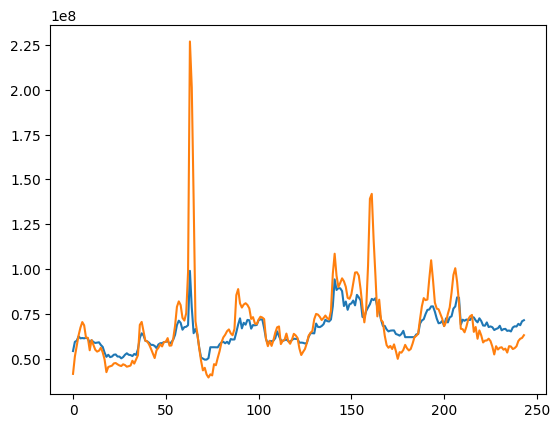

In [11]:
plt.plot(clfs[0].predict(X))
plt.plot(y)
plt.show()

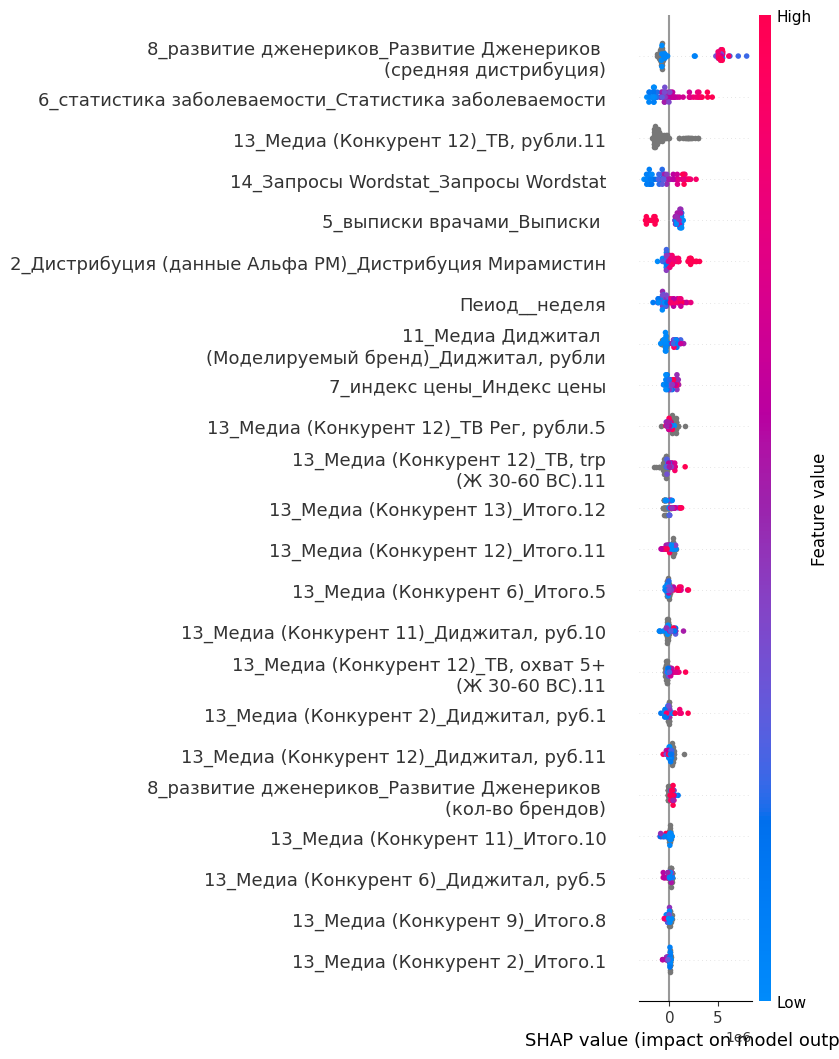

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=30)

In [13]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['feature_importance_vals'] = feature_importance['feature_importance_vals'].round(2)
feature_importance.head(20).col_name.values

array(['8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция)',
       '6_статистика заболеваемости_Статистика заболеваемости',
       '13_Медиа (Конкурент 12)_ТВ, рубли.11',
       '14_Запросы Wordstat_Запросы Wordstat',
       '5_выписки врачами_Выписки ',
       '2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин',
       'Пеиод__неделя',
       '11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли',
       '7_индекс цены_Индекс цены',
       '13_Медиа (Конкурент 12)_ТВ Рег, рубли.5',
       '13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11',
       '13_Медиа (Конкурент 13)_Итого.12',
       '13_Медиа (Конкурент 12)_Итого.11',
       '13_Медиа (Конкурент 6)_Итого.5',
       '13_Медиа (Конкурент 11)_Диджитал, руб.10',
       '13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11',
       '13_Медиа (Конкурент 2)_Диджитал, руб.1',
       '13_Медиа (Конкурент 12)_Диджитал, руб.11',
       '8_развитие дженериков_Развитие Дженериков \n(кол-во брендов)',
       '13_Меди

## Feature prediction

In [14]:
COLUMNS_TO_PREDICT = [
       '1_KPI \nданные понедельно АлфаРМ_Продажи, рубли',
       '8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция)',
       '6_статистика заболеваемости_Статистика заболеваемости',
       '13_Медиа (Конкурент 12)_ТВ, рубли.11',
       '14_Запросы Wordstat_Запросы Wordstat',
       '5_выписки врачами_Выписки ',
       '2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин',
       'Пеиод__неделя',
       '11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли',
       '13_Медиа (Конкурент 12)_ТВ Рег, рубли.5',
       '13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11',
       '7_индекс цены_Индекс цены', '13_Медиа (Конкурент 12)_Итого.11',
       '13_Медиа (Конкурент 13)_Итого.12',
       '13_Медиа (Конкурент 6)_Итого.5',
       '13_Медиа (Конкурент 12)_ТВ, охват 5+\n(Ж 30-60 ВС).11',
       '13_Медиа (Конкурент 2)_Диджитал, руб.1',
       '13_Медиа (Конкурент 11)_Диджитал, руб.10',
       '13_Медиа (Конкурент 11)_Итого.10',
       '13_Медиа (Конкурент 12)_Диджитал, руб.11',
       '8_развитие дженериков_Развитие Дженериков \n(кол-во брендов)']

In [15]:
corr_matrix = small_df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
small_df.drop(to_drop, axis=1, inplace=True)
# len(to_drop), small_df.shape
COLUMNS_TO_PREDICT = [x for x in COLUMNS_TO_PREDICT if x in small_df.columns]

In [25]:
small_df.head()

,Пеиод__неделя,Пеиод__Начало нед,"1_KPI \nданные понедельно АлфаРМ_Продажи, рубли",2_Дистрибуция (данные Альфа РМ)_Дистрибуция Мирамистин,5_выписки врачами_Выписки,6_статистика заболеваемости_Статистика заболеваемости,7_индекс цены_Индекс цены,8_развитие дженериков_Развитие Дженериков \n(средняя дистрибуция),"11_Медиа Диджитал \n(Моделируемый бренд)_Диджитал, рубли",14_Запросы Wordstat_Запросы Wordstat,...,13_Медиа (Конкурент 11)_Итого.10,"13_Медиа (Конкурент 12)_ТВ, trp\n(Ж 30-60 ВС).11","13_Медиа (Конкурент 12)_ТВ, рубли.11","13_Медиа (Конкурент 12)_Диджитал, руб.11","13_Медиа (Конкурент 12)_ТВ Рег, рубли.5",13_Медиа (Конкурент 12)_Итого.11,13_Медиа (Конкурент 13)_Итого.12,timestamp,day,month
0,1,2018-12-31,4.153557e+07,0.92107,99698.595433,508956.0,1.54132,NaN,1057612.5,76854.75,...,5.897845e+06,191.587053,1645238.9337096778,3.033352e+06,7.155664e+06,1.183425e+07,9.085528e+06,2018-12-31,31,12
1,2,2019-01-07,5.122229e+07,0.92107,99698.595433,804825.0,1.54132,NaN,844452.0,89113.50,...,6.844746e+06,142.215997,1919445.4226612907,3.728812e+06,8.348274e+06,1.399653e+07,1.059978e+07,2019-01-07,7,1
2,3,2019-01-14,5.712735e+07,0.92107,99698.595433,993384.0,1.54132,NaN,1235682.0,96066.60,...,7.599864e+06,98.844036,1919445.4226612907,1.198575e+06,8.348274e+06,1.146629e+07,1.059978e+07,2019-01-14,14,1
3,4,2019-01-21,6.304099e+07,0.92107,99698.595433,1186542.0,1.54132,NaN,538272.0,99189.30,...,7.513113e+06,201.975398,1919445.4226612907,4.969125e+05,8.348274e+06,1.076463e+07,1.059978e+07,2019-01-21,21,1
4,5,2019-01-28,6.733689e+07,0.92107,99698.595433,1454817.0,1.54132,NaN,NaN,108418.80,...,1.059384e+07,105.756137,1911792.1603064518,5.961375e+05,8.477038e+06,1.098497e+07,1.289309e+07,2019-01-28,28,1


In [17]:
small_df['timestamp'] = pd.to_datetime(small_df['Пеиод__Начало нед'])
small_df['day'] = small_df['timestamp'].map(lambda x: x.day)
small_df['month'] = small_df['timestamp'].map(lambda x: x.month)

In [18]:
train_selected, test_selected = small_df.iloc[:200].copy(), small_df.iloc[200:].copy()
df_with_selected_features = train_selected[COLUMNS_TO_PREDICT + ['day', 'month']].copy()
test_selected_ = test_selected[COLUMNS_TO_PREDICT + ['day', 'month']].copy()
WINDOW = 20

for column in COLUMNS_TO_PREDICT:
    for i in range(WINDOW):
        df_with_selected_features[f"{column}_lag{i + 1}"] = df_with_selected_features[column].shift(i + 1).copy()
        test_selected_[f"{column}_lag{i + 1}"] = test_selected_[column].shift(i + 1).copy()

df_with_selected_features.drop(columns=COLUMNS_TO_PREDICT, inplace=True)
test_selected_.drop(columns=COLUMNS_TO_PREDICT, inplace=True)

In [19]:
df_with_selected_features.shape, WINDOW * len(COLUMNS_TO_PREDICT)

((200, 382), 380)

In [20]:
all_clfs = []
i = -1
for cur_column in COLUMNS_TO_PREDICT:
    i += 1
    tmp_df = df_with_selected_features.copy()
    tmp_df[cur_column] = small_df[cur_column].copy()
    tmp_df = tmp_df[~tmp_df[cur_column].isna()]
    print(i, cur_column, tmp_df.shape)

    model = CatBoostRegressor(
            depth=3,
            iterations=200,
            learning_rate=0.1,
            loss_function='MAPE', 
            eval_metric="MAPE", 
            custom_metric="MAPE",
            boosting_type="Ordered",
            
            # Главная фишка катбуста - работа с категориальными признаками
            cat_features=cat_features,
            # ignored_features = ignored_features,
            
            # Регуляризация и ускорение
            colsample_bylevel=0.1,
            subsample=0.95,
            l2_leaf_reg=3,
            min_data_in_leaf=243,
            max_bin=187,
            random_strength=5,
            
            # Параметры ускорения
            task_type="CPU",    
            thread_count=-1,
            bootstrap_type="Bernoulli", 
            
            # Важное!
            random_seed=7575,
            # auto_class_weights="SqrtBalanced",
            early_stopping_rounds=50)
    
    cur_clfs = train_regressor_model(tmp_df.drop(columns=[cur_column]), tmp_df[cur_column], 2, cat_features, model)
    all_clfs.append(cur_clfs)

0 1_KPI 
данные понедельно АлфаРМ_Продажи, рубли (200, 383)
0:	learn: 0.1657050	test: 0.2244969	best: 0.2244969 (0)	total: 5.4ms	remaining: 1.07s
100:	learn: 0.1010001	test: 0.2059095	best: 0.2054962 (96)	total: 951ms	remaining: 932ms
199:	learn: 0.0710953	test: 0.1714563	best: 0.1712570 (173)	total: 1.79s	remaining: 0us

bestTest = 0.1712569648
bestIteration = 173

Shrink model to first 174 iterations.
fold: MAPE score: 0.17125696432743978
1 8_развитие дженериков_Развитие Дженериков 
(средняя дистрибуция) (95, 383)
0:	learn: 0.0044075	test: 0.0228934	best: 0.0228934 (0)	total: 8.88ms	remaining: 1.77s
100:	learn: 0.0004540	test: 0.0174131	best: 0.0173924 (90)	total: 746ms	remaining: 731ms
199:	learn: 0.0002254	test: 0.0172958	best: 0.0172884 (188)	total: 1.5s	remaining: 0us

bestTest = 0.01728841035
bestIteration = 188

Shrink model to first 189 iterations.
fold: MAPE score: 0.41558106274664947
2 6_статистика заболеваемости_Статистика заболеваемости (200, 383)
0:	learn: 0.4173498	test:

## predicts

In [21]:
cur_list = test_selected_.iloc[-1].values.tolist()[2:]
cur_date = test_selected.iloc[-1]['timestamp']
full_preds = []
timestamps = []
for shift in range(29):
    new_values = []
    for i, clf in enumerate(all_clfs):
        new_values.append(np.mean([clf[x].predict([cur_date.day, cur_date.month] + cur_list) for x in range(1)]))
    for i in range(len(COLUMNS_TO_PREDICT)):
        cur_list = cur_list[:i * WINDOW] + [new_values[i]] + cur_list[i * WINDOW:(i + 1) * WINDOW][:-1] + cur_list[(i + 1) * WINDOW:]
    cur_date = cur_date + pd.Timedelta(days=7)
    timestamps.append(cur_date)
    full_preds.append(new_values)

In [22]:
subm_df = pd.DataFrame()
subm_df['week'] = list(map(lambda x: pd.to_datetime(x).strftime('%d.%m.%Y'), timestamps))
subm_df['revenue'] = [x[0] for x in full_preds]

subm_df.to_csv('subm_catb.csv', index=False)

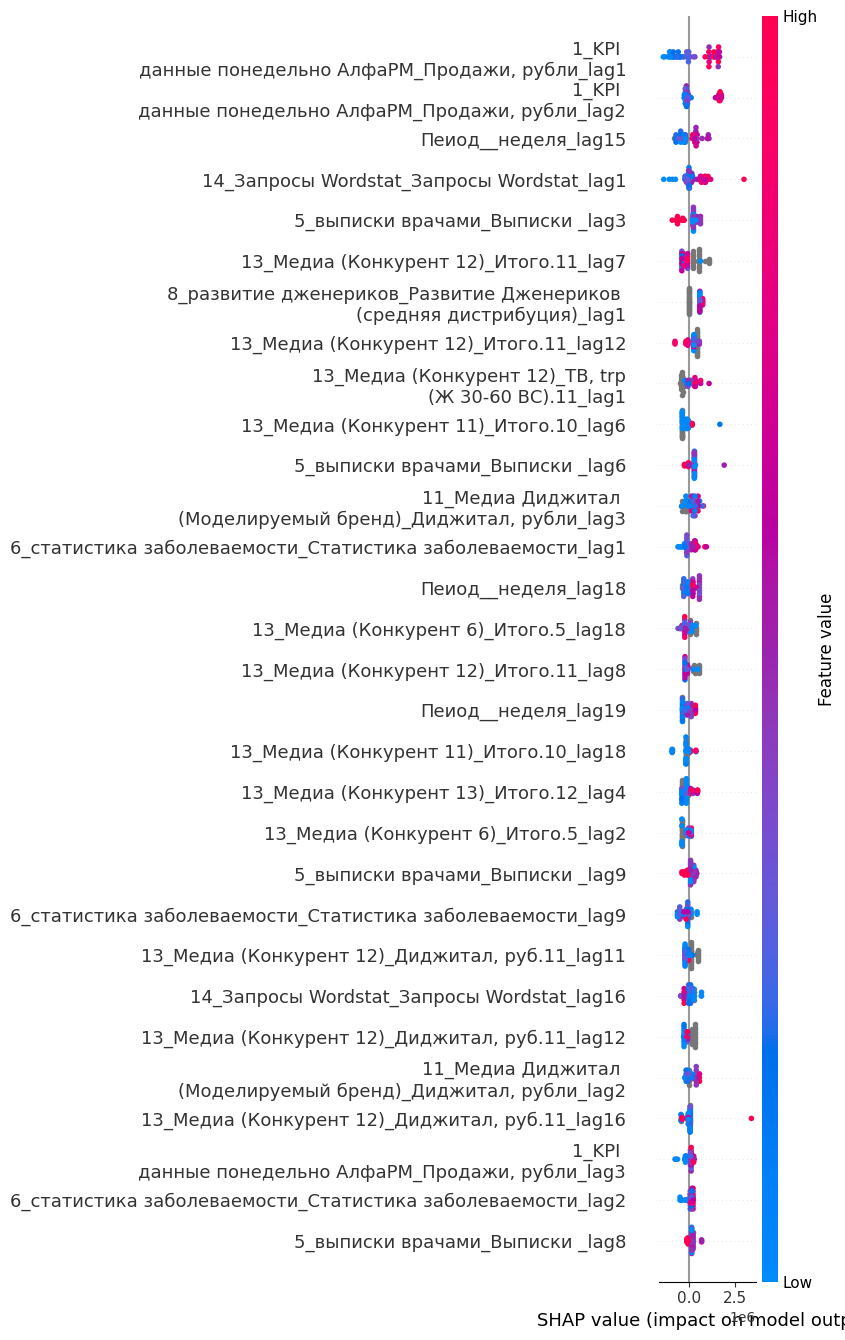

In [24]:
I = 0
X_train, X_test, y_train, y_test = train_test_split(df_with_selected_features, train_selected[COLUMNS_TO_PREDICT[I]].values, test_size=0.3)
explainer = shap.TreeExplainer(all_clfs[I][0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=30)